# UBS Stock Data

In [181]:
import pandas as pd
import os
#%pip install pytrends
import pytrends
from pytrends.request import TrendReq
#pip install pageviewapi
import pageviewapi
#%pip install yfinance
import yfinance as yf
#! pip install pandas-ta
import pandas_ta as ta

In [182]:
def Big_scraper(kw_list_1, kw_list_2, ticker, start,end):
    
    """
    Description:
    ------------
    
    The function initially grabs historical, indexed, hourly data for when the keyword 
    was searched most as shown on Google Trends' Interest Over Time section.
    It then cleans the data to show daily hits on the keyword in Google news.

    
    input:
    -----
    kw_list_1: List of up to 5 key words that will be scraped from google trends for the dates given.
             Here, the scraping will pull the total posted items in google news that contains
             one of the key words.
    
    kw_list_2: List of wikipedia article titles (unlimited length) that will pull the amount of
            views the article recieved each day. 

    ticker: the ticker abriviation of the desired stock. Must be netered in as an all capitalized string 
    example UBS Inc. woud be "UBS"
             
    start: the start of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
    
    end: the end of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
             
    return:
    -------
    
    combined: a dataframe containing the sum of the daily keyword hits in google news (key words labeled _x),
    
    data frame cointaing stock info including open, close, high, low prices of the stock,
    as well as the stocks daily trading volume and the amount if there was a split or dividend 
    preformed on the stock that day,
    
    and the sum of how many times key word wikipedia pages were viewed in a day (key words labeled _y)
    """
    
    year_s = int(start[0:4])
    month_s = int(start[4:6])
    day_s = int(start[6:8])
    year_e = int(end[0:4])
    month_e = int(end[4:6])
    day_e = int(end[6:8])
    
    starter = pd.to_datetime(f"'{year_s}-{month_s}-{day_s}'")
    ender = pd.to_datetime(f"'{year_e}-{month_e}-{day_e}'")
    
    
    pytrends = TrendReq(hl='en-US', tz=360, retries=10)
    jeff = pytrends.get_historical_interest(kw_list_1, \
                                 year_start = year_s, month_start = month_s, day_start = day_s, hour_start = 1, \
                                 year_end = year_e, month_end = month_e, day_end = day_e, hour_end = 23, \
                                 cat = 0, geo = '', gprop = 'news', sleep = 60)
    
    jeff = jeff.iloc[:, 0:-1] # eliminates the isPartial Column
    jeff = jeff.reset_index().drop_duplicates(subset = "date") #removing duplicates from the index
    jeff = jeff.groupby(pd.Grouper(key="date", freq="D")).mean() # coverts to the mean of daily search score
    
    dow = yf.Ticker("^DJI")
    dow_h = dow.history(start=starter, end=ender)
    dow_h = pd.DataFrame(dow_h)
    dow_names = {"Open":"dow_open","Close":"dow_close","Low": "dow_low",
    'High':'dow_high','Volume':'dow_vol'}
    dow_h=dow_h.rename(dow_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    nas = yf.Ticker("^IXIC")
    nas_h = nas.history(start=starter, end=ender)
    nas_h = pd.DataFrame(nas_h)
    nas_names = {"Open":"nas_open", "Close":"nas_close", "Low": "nas_low",
    'High':'nas_high','Volume':'nas_vol'}
    nas_h=nas_h.rename(nas_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    market = dow_h.merge(nas_h,left_index=True, right_index=True, how="left")

    tick = yf.Ticker(ticker)
    hist = tick.history(start=starter, end=ender)
    hist = pd.DataFrame(hist)
    
    combined = jeff.merge(hist, left_index=True, right_index=True, how="left") 
    
    d = pd.DataFrame()
    for key_word in kw_list_2:
        geoff = pageviewapi.per_article('en.wikipedia', key_word, start, end,
                                    access='all-access', agent='all-agents', granularity='daily')
        dicty = dict(geoff)
        views = pd.DataFrame(dicty["items"])
        views["timestamp"] = pd.to_datetime((views["timestamp"]), format="%Y%m%d%H")
        views = views.set_index("timestamp")
        page = pd.Series(views["views"])
        d[key_word] = page
        
    combined = combined.merge(d, left_index=True, right_index=True, how="left") 
    
    return combined

In [183]:
kw_list_1 = ["UBS", "UBS Financial Services Inc.", "UBS Investment Bank", "UBS Global Wealth Management", "UBS Asset Management"]
kw_list_2 = ["UBS", "Union Bank of Switzerland", "UBS tax evasion controversies", "Banking in Switzerland"]

In [184]:
# UBS = Big_scraper(kw_list_1, kw_list_2,"UBS", "20190101", "20220331")

In [185]:
# UBS.head()

In [186]:
# UBS.to_csv("UBS_Full_Data.csv")

In [187]:
def Big_scraper(kw_list_1, kw_list_2, ticker, start,end):
    
    """
    Description:
    ------------
    
    The function initially grabs historical, indexed, hourly data for when the keyword 
    was searched most as shown on Google Trends' Interest Over Time section.
    It then cleans the data to show daily hits on the keyword in Google news.

    
    input:
    -----
    kw_list_1: List of up to 5 key words that will be scraped from google trends for the dates given.
             Here, the scraping will pull the total posted items in google news that contains
             one of the key words.
    
    kw_list_2: List of wikipedia article titles (unlimited length) that will pull the amount of
            views the article recieved each day. 

    ticker: the ticker abriviation of the desired stock. Must be netered in as an all capitalized string 
    example UBS Inc. woud be "UBS"
             
    start: the start of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
    
    end: the end of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
             
    return:
    -------
    
    combined: a dataframe containing the sum of the daily keyword hits in google news (key words labeled _x),
    
    data frame cointaing stock info including open, close, high, low prices of the stock,
    as well as the stocks daily trading volume and the amount if there was a split or dividend 
    preformed on the stock that day,
    
    and the sum of how many times key word wikipedia pages were viewed in a day (key words labeled _y)
    """
    
    year_s = int(start[0:4])
    month_s = int(start[4:6])
    day_s = int(start[6:8])
    year_e = int(end[0:4])
    month_e = int(end[4:6])
    day_e = int(end[6:8])
    
    starter = pd.to_datetime(f"'{year_s}-{month_s}-{day_s}'")
    ender = pd.to_datetime(f"'{year_e}-{month_e}-{day_e}'")
    
    dow = yf.Ticker("^DJI")
    dow_h = dow.history(start=starter, end=ender)
    dow_h = pd.DataFrame(dow_h)
    dow_names = {"Open":"dow_open","Close":"dow_close","Low": "dow_low",
    'High':'dow_high','Volume':'dow_vol'}
    dow_h=dow_h.rename(dow_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    nas = yf.Ticker("^IXIC")
    nas_h = nas.history(start=starter, end=ender)
    nas_h = pd.DataFrame(nas_h)
    nas_names = {"Open":"nas_open", "Close":"nas_close", "Low": "nas_low",
    'High':'nas_high','Volume':'nas_vol'}
    nas_h=nas_h.rename(nas_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    market = dow_h.merge(nas_h,left_index=True, right_index=True, how="left")
    
    return market

In [188]:
Nas_Dow = Big_scraper(kw_list_1, kw_list_2,"UBS", "20190101", "20220331")
Nas_Dow.index.names = ['date']
Nas_Dow

,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol
date,,,,,,,,,,
2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,321570000,6506.910156,6693.709961,6506.879883,6665.939941,2261800000
2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,424240000,6584.770020,6600.209961,6457.129883,6463.500000,2607290000
2019-01-04,22894.919922,23518.640625,22894.919922,23433.160156,396020000,6567.140137,6760.689941,6554.240234,6738.859863,2579550000
2019-01-07,23474.259766,23687.740234,23301.589844,23531.349609,334200000,6757.529785,6855.600098,6741.399902,6823.470215,2507550000
2019-01-08,23680.320312,23864.650391,23581.449219,23787.449219,317420000,6893.439941,6909.580078,6795.859863,6897.000000,2380290000
...,...,...,...,...,...,...,...,...,...,...
2022-03-24,34406.808594,34713.558594,34355.421875,34707.941406,324870000,14001.320312,14193.549805,13897.200195,14191.839844,5046250000
2022-03-25,34702.390625,34942.699219,34631.519531,34861.238281,285440000,14194.719727,14218.759766,14010.790039,14169.299805,5553860000
2022-03-28,34833.031250,34957.929688,34552.230469,34955.890625,299790000,14177.209961,14356.000000,14101.339844,14354.900391,5086120000


In [189]:
Nas_Dow.to_csv("Nas_Dow_Data.csv")

Raw data saved, now we will read it back in to start cleaning it.

## Data Clean and Shape

In [190]:
UBS = pd.read_csv("UBS_Full_Data.csv")
UBS.head()

,date,UBS_x,UBS Financial Services Inc.,UBS Investment Bank,UBS Global Wealth Management,UBS Asset Management,Open,High,Low,Close,Volume,Dividends,Stock Splits,UBS_y,Union Bank of Switzerland,UBS tax evasion controversies,Banking in Switzerland
0,2019-01-01,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960,91,25,328
1,2019-01-02,6.708333,0.0,0.0,0.0,0.0,10.378242,10.700180,10.282508,10.632403,3210100.0,0.0,0.0,1402,117,29,399
2,2019-01-03,5.708333,0.0,0.0,0.0,0.0,10.522266,10.606987,10.465503,10.496850,2534700.0,0.0,0.0,1556,126,15,421
3,2019-01-04,14.791667,0.0,0.0,0.0,0.0,10.734068,10.937397,10.687472,10.878093,2743500.0,0.0,0.0,1467,125,29,398
4,2019-01-05,9.125000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1154,105,19,382


In [191]:
#converting the date column back to datetime 
UBS.date = pd.to_datetime(UBS.date)

In [192]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# create dateframe 2019-01-01 to 2022-03-31 which excludes weekends and holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
dates = pd.date_range(start='2019-01-01', end='2022-03-31', freq=us_bd)
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0: "date"})

# Merge on new date range to remove weekends and holidays in netflix dataset
UBSS = dates.merge(UBS, on="date", how="left")
UBSS = UBSS.set_index("date")
UBSS.head()


,UBS_x,UBS Financial Services Inc.,UBS Investment Bank,UBS Global Wealth Management,UBS Asset Management,Open,High,Low,Close,Volume,Dividends,Stock Splits,UBS_y,Union Bank of Switzerland,UBS tax evasion controversies,Banking in Switzerland
date,,,,,,,,,,,,,,,,
2019-01-02,6.708333,0.0,0.0,0.0,0.0,10.378242,10.700180,10.282508,10.632403,3210100.0,0.0,0.0,1402,117,29,399
2019-01-03,5.708333,0.0,0.0,0.0,0.0,10.522266,10.606987,10.465503,10.496850,2534700.0,0.0,0.0,1556,126,15,421
2019-01-04,14.791667,0.0,0.0,0.0,0.0,10.734068,10.937397,10.687472,10.878093,2743500.0,0.0,0.0,1467,125,29,398
2019-01-07,12.208333,0.0,0.0,0.0,0.0,10.878092,11.056005,10.823024,10.988229,3163300.0,0.0,0.0,2017,130,37,418
2019-01-08,2.333333,0.0,0.0,0.0,0.0,11.047532,11.089893,10.945868,11.013644,2384500.0,0.0,0.0,2023,146,39,422


In [193]:
# Merge UBS and Nas_Dow
UBS = UBSS.merge(Nas_Dow, on="date")
UBS.head()

,UBS_x,UBS Financial Services Inc.,UBS Investment Bank,UBS Global Wealth Management,UBS Asset Management,Open,High,Low,Close,Volume,Dividends,Stock Splits,UBS_y,Union Bank of Switzerland,UBS tax evasion controversies,Banking in Switzerland,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.708333,0.0,0.0,0.0,0.0,10.378242,10.700180,10.282508,10.632403,3210100.0,0.0,0.0,1402,117,29,399,23058.609375,23413.470703,22928.589844,23346.240234,321570000,6506.910156,6693.709961,6506.879883,6665.939941,2261800000
2019-01-03,5.708333,0.0,0.0,0.0,0.0,10.522266,10.606987,10.465503,10.496850,2534700.0,0.0,0.0,1556,126,15,421,23176.390625,23176.390625,22638.410156,22686.220703,424240000,6584.770020,6600.209961,6457.129883,6463.500000,2607290000
2019-01-04,14.791667,0.0,0.0,0.0,0.0,10.734068,10.937397,10.687472,10.878093,2743500.0,0.0,0.0,1467,125,29,398,22894.919922,23518.640625,22894.919922,23433.160156,396020000,6567.140137,6760.689941,6554.240234,6738.859863,2579550000
2019-01-07,12.208333,0.0,0.0,0.0,0.0,10.878092,11.056005,10.823024,10.988229,3163300.0,0.0,0.0,2017,130,37,418,23474.259766,23687.740234,23301.589844,23531.349609,334200000,6757.529785,6855.600098,6741.399902,6823.470215,2507550000
2019-01-08,2.333333,0.0,0.0,0.0,0.0,11.047532,11.089893,10.945868,11.013644,2384500.0,0.0,0.0,2023,146,39,422,23680.320312,23864.650391,23581.449219,23787.449219,317420000,6893.439941,6909.580078,6795.859863,6897.000000,2380290000


In [194]:
# creating base varibles to be used in variable creator functions
UBS["Wiki_total"] = (UBS["UBS_x"] + 
    UBS["Union Bank of Switzerland"] + UBS["UBS tax evasion controversies"] + 
    UBS["Banking in Switzerland"])

UBS["Google_total"] = (UBS["UBS_y"] +
    UBS["UBS Financial Services Inc."] + UBS["UBS Investment Bank"] +
    UBS["UBS Global Wealth Management"] + UBS["UBS Asset Management"])

UBS["Stock_total"] = UBS["Close"]
UBS["Nas_total"] = UBS["nas_close"]
UBS["Dow_total"] = UBS["dow_close"]

In [211]:
def variables_creator(df, variable_list, w=5):
    
    '''
    descrition:
    -----------
    takes dataframe and returns new varibles based on recommmended calcualtions, 
    it should be done seporately with internet based and stock based dataframes

    Note: When using for aggreated varaibles, for example Wiki_total, the sum of all the wiki pages daily page view counts, 
    you MUST calculate Wiki_total in the dataframe seperately BEFORE this function can be used. 

    For example if you had wiki page counts for Union Bank of Switzerland and UBS tax evasion controversies, Wiki_total would equal Union Bank of Switzerland + UBS tax evasion controversies counts, 
    AGAIN Wiki_total must be calculated in the desired dateframe before using this function 

    input:
    ------
    df: dataframe containing the google trends, yahoo finance, and or wikipedia page count data

    variable_list: list of strings to be added to the equations to calculate the new varaibles. 
    ex. inserting the string "Wiki" will add to df[f"{}_total"] to become "Wiki_total"

    w: the window length for one period shift. Default is 7 providing 7 day moving averages for wiki and google data, 
        FOR STOCK DATA THIS WILL NEED TO BE CHANGED TO 5.

    output:
    -------
    df: the same dataframe as was inputted but now containing variables for 
    Momemtum, Disparity, Moving Average, Exponential Moving Aerage, Rator Change, and RSI index score.
    Also containg are moving variables, which are boolean with 1 indicating an increase in the above variables
    '''   
    
    for i in variable_list:
        # Momentum_1
        df[f"{i}_Moment_1"] =  (df[f"{i}_total"] / df[f"{i}_total"].shift(w)) * 100
        # Momentum_2
        df[f"{i}_Moment_2"] =  (df[f"{i}_total"] - df[f"{i}_total"].shift(w)) * 100
        # Momentum_1_s three day shift (instead of w)
        df[f"{i}_Moment_1_s"] =  (df[f"{i}_total"] / df[f"{i}_total"].shift(3)) * 100
        # Momentum_2_s
        df[f"{i}_Moment_2_s"] =  (df[f"{i}_total"] - df[f"{i}_total"].shift(3)) * 100
        # Moving average
        df[f"{i}_MAvg"] = df[f"{i}_total"].rolling(f"{w}d").mean()
        # Moving average 3 day
        df[f"{i}_MAvg_s"] = df[f"{i}_total"].rolling("3d").mean()
        # Moving average 5 day
        df[f"{i}_MAvg_s_5"] = df[f"{i}_total"].rolling("5d").mean()
        # Moving average 6 day
        df[f"{i}_MAvg_s_6"] = df[f"{i}_total"].rolling("6d").mean()
        # Disparity
        df[f"{i}_Disparity"] = (df[f"{i}_total"]/df[f"{i}_MAvg"]) * 100
        # Disparity 3 day
        df[f"{i}_Disparity_s"] = (df[f"{i}_total"]/df[f"{i}_MAvg_s"]) * 100
        # Disparity 5 day
        df[f"{i}_Disparity_s_5"] = (df[f"{i}_total"]/df[f"{i}_MAvg_s_5"]) * 100
        # Rate of Change Normal Way
        df[f"{i}_ROC"] = (df[f"{i}_total"]-df[f"{i}_total"].shift(w))/(df[f"{i}_total"].shift(w)) *100
        df[f"{i}_ROC_s"] = (df[f"{i}_total"]-df[f"{i}_total"].shift(3))/(df[f"{i}_total"].shift(3)) *100
        #Rate of Change Paper Way (doesn't make sense but just in case)
        df[f'{i}_Rocp'] = (df[f"{i}_total"]/df[f"{i}_Moment_2"]) *100
        # Exponential Moving Average for 1 day
        df[f"{i}_EMA"] = (df[f"{i}_total"]-df[f"{i}_MAvg"].shift(1))*(2/(w+1))+df[f"{i}_MAvg"].shift(1)
        # Exponential Moving Average for 5 days
        df[f"{i}_EMA_5"] = (df[f"{i}_total"]-df[f"{i}_MAvg"].shift(5))*(2/(w+1))+df[f"{i}_MAvg"].shift(5)

        # Calculating the Relative Strength Index, based on 14 day window
        df[f"{i}_diff"] = df[f"{i}_total"].diff(1)
        df[f"{i}_gain"] = df[f"{i}_diff"].clip(lower=0).round(2) #keeps all values above or below a given threshold, lower=lower bound
        df[f"{i}_loss"] = df[f"{i}_diff"].clip(upper=0).round(2)
        df[f'{i}_avg_gain'] = df[f'{i}_gain'].rolling(14).mean()
        df[f'{i}_avg_loss'] = df[f'{i}_loss'].rolling(14).mean()
        df[f'{i}_rs'] = df[f'{i}_avg_gain'] / df[f'{i}_avg_loss']
        df[f'{i}_RSI'] = 100 - (100 / (1.0 + df[f'{i}_rs']))

        # Calculating the Stochastic Oscillator, based on 14 day window
        # Add some indicators --> First: import pandas_ta as ta 
        df[["Stoch_Oscillator_3","Stoch_Oscillator_14"]] = df.ta.stoch(high='high', low='low', k=14, d=3, append=True) # the package pandas_ta calculates the stochastic oscillator

        # Calculating the Change in Close
        df["Change_Close"] = (df["Close"].shift(-1) - df["Close"])
        # Calculating the Change in Google
        df["Change_Google"] = (df["Google_total"].shift(-1) - df["Google_total"])

        # Calculatiing the Move Variables 
        df[f"{i}_Move"] = df[f"{i}_total"] > df[f"{i}_total"].shift(1) 
        df[f"{i}_Move"] = df[f"{i}_Move"].replace({True:1,False: 0})
    
        df[f"{i}_MAvg_Move"] = df[f"{i}_MAvg"] > df[f"{i}_MAvg"].shift(1) 
        df[f"{i}_MAvg_Move"] = df[f"{i}_MAvg_Move"].replace({True:1,False: 0})
        df[f"{i}_MAvg_s_Move"] = df[f"{i}_MAvg_s"] > df[f"{i}_MAvg_s"].shift(1) 
        df[f"{i}_MAvg_s_Move"] = df[f"{i}_MAvg_s_Move"].replace({True:1,False: 0})

        df[f"{i}_EMA_Move"] = df[f"{i}_EMA"] > df[f"{i}_EMA"].shift(1) 
        df[f"{i}_EMA_Move"] = df[f"{i}_EMA_Move"].replace({True:1,False: 0})

        df[f"{i}_EMA_Move_5"] = df[f"{i}_EMA_5"] > df[f"{i}_EMA_5"].shift(1) 
        df[f"{i}_EMA_Move_5"] = df[f"{i}_EMA_Move"].replace({True:1,False: 0})

        df[f"{i}_Disparity_Move"] = df[f"{i}_Disparity"] > df[f"{i}_Disparity"].shift(1) 
        df[f"{i}_Disparity_Move"] = df[f"{i}_Disparity_Move"].replace({True:1,False: 0})
        df[f"{i}_Disparity_s_Move"] = df[f"{i}_Disparity_s"] > df[f"{i}_Disparity_s"].shift(1) 
        df[f"{i}_Disparity_s_Move"] = df[f"{i}_Disparity_s_Move"].replace({True:1,False: 0})

        df[f"{i}_RSI_Move"] = df[f"{i}_RSI"] > df[f"{i}_RSI"].shift(1) 
        df[f"{i}_RSI_Move"] = df[f"{i}_RSI_Move"].replace({True:1,False: 0})
        
    return df

In [212]:
UBS = variables_creator(UBS, ["Wiki","Google", "Stock", "Nas", "Dow"], 5)

In [213]:
def target_creator(df):
    '''
    description: creates the differnt types of target variables based on tomorrow minus today,
    '''
        
    # target 1, Open(t+1) - Close(t)
    df["target_1"] = (df["Open"].shift(-1) - df["Close"]) > 0
    df["target_1"] = df["target_1"].replace({True:1,False: 0})

    # target 2, Open(t+1) - Open(t)
    df["target_2"] = (df["Open"].shift(-1) - df["Open"]) > 0
    df["target_2"] = df["target_2"].replace({True:1,False: 0})

    # target 3, Close(t+1) - Close(t)
    df["target_3"] = (df["Close"].shift(-1) - df["Close"]) > 0
    df["target_3"] = df["target_3"].replace({True:1,False: 0})

    # target 4, Close(t+1) - Open(t)
    df["target_4"] = (df["Close"].shift(-1) - df["Open"]) > 0
    df["target_4"] = df["target_4"].replace({True:1,False: 0})

    # target 5, Trade Volume(t+1) - Trade Volume(t)
    df["target_5"] = (df["Volume"].shift(-1) - df["Volume"]) > 0
    df["target_5"] = df["target_5"].replace({True:1,False: 0})
 
    return df

In [214]:
UBS = target_creator(UBS)


In [215]:
# Some cleaning
UBS = UBS.drop(columns=['STOCHk_14_3_3', 'STOCHd_14_3_3'])#, 'SOOOOO', 'SIIII'])

In [216]:
pd.set_option('display.max_columns', None)
UBS.head()

,UBS_x,UBS Financial Services Inc.,UBS Investment Bank,UBS Global Wealth Management,UBS Asset Management,Open,High,Low,Close,Volume,Dividends,Stock Splits,UBS_y,Union Bank of Switzerland,UBS tax evasion controversies,Banking in Switzerland,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_Disparity,Wiki_Disparity_s,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Stoch_Oscillator_3,Stoch_Oscillator_14,Change_Close,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_EMA_Move,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_Disparity,Google_Disparity_s,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_EMA_Move,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_Disparity,Stock_Disparity_s,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_EMA_Move,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_Disparity,Nas_Disparity_s,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_EMA_Move,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_Disparity,Dow_Disparity_s,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5,Wiki_EMA_5,Google_EMA_5,Stock_EMA_5,Nas_EMA_5,Dow_EMA_5,Wiki_MAvg_s_5,Wiki_MAvg_s_6,Wiki_Disparity_s_5,Change_Google,Wiki_EMA_Move_5,Google_MAvg_s_5,Google_MAvg_s_6,Google_Disparity_s_5,Google_EMA_Move_5,Stock_MAvg_s_5,Stock_MAvg_s_6,Stock_Disparity_s_5,Stock_EMA_Move_5,Nas_MAvg_s_5,Nas_MAvg_s_6,Nas_Disparity_s_5,Nas_EMA_Move_5,Dow_MAvg_s_5,Dow_MAvg_s_6,Dow_Disparity_s_5,Dow_EMA_Move_5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.708333,0.0,0.0,0.0,0.0,10.378242,10.700180,10.282508,10.632403,3210100.0,0.0,0.0,1402,117,29,399,23058.609375,23413.470703,22928.589844,23346.240234,321570000,6506.910156,6693.709961,6506.879883,6665.939941,2261800000,551.708333,1402.0,10.632403,6665.939941,23346.240234,NaN,NaN,NaN,NaN,551.708333,551.708333,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.135553,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,1402.000000,1402.0,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,10.632403,10.632403,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,6665.939941,6665.939941,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,23346.240234,23346.240234,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,551.708333,551.708333,100.000000,154.0,0,1402.000000,1402.00,100.000000,0,10.632403,10.632403,100.000000,0,6665.939941,6665.939941,100.000000,0,23346.240234,23346.240234,100.000000,0
2019-01-03,5.708333,0.0,0.0,0.0,0.0,10.522266,10.606987,10.465503,10.496850,2534700.0,0.0,0.0,1556

In [201]:
UBS.to_csv("UBS_Cleaned_Date.csv")

## Initial Variable Slection 

<AxesSubplot:>

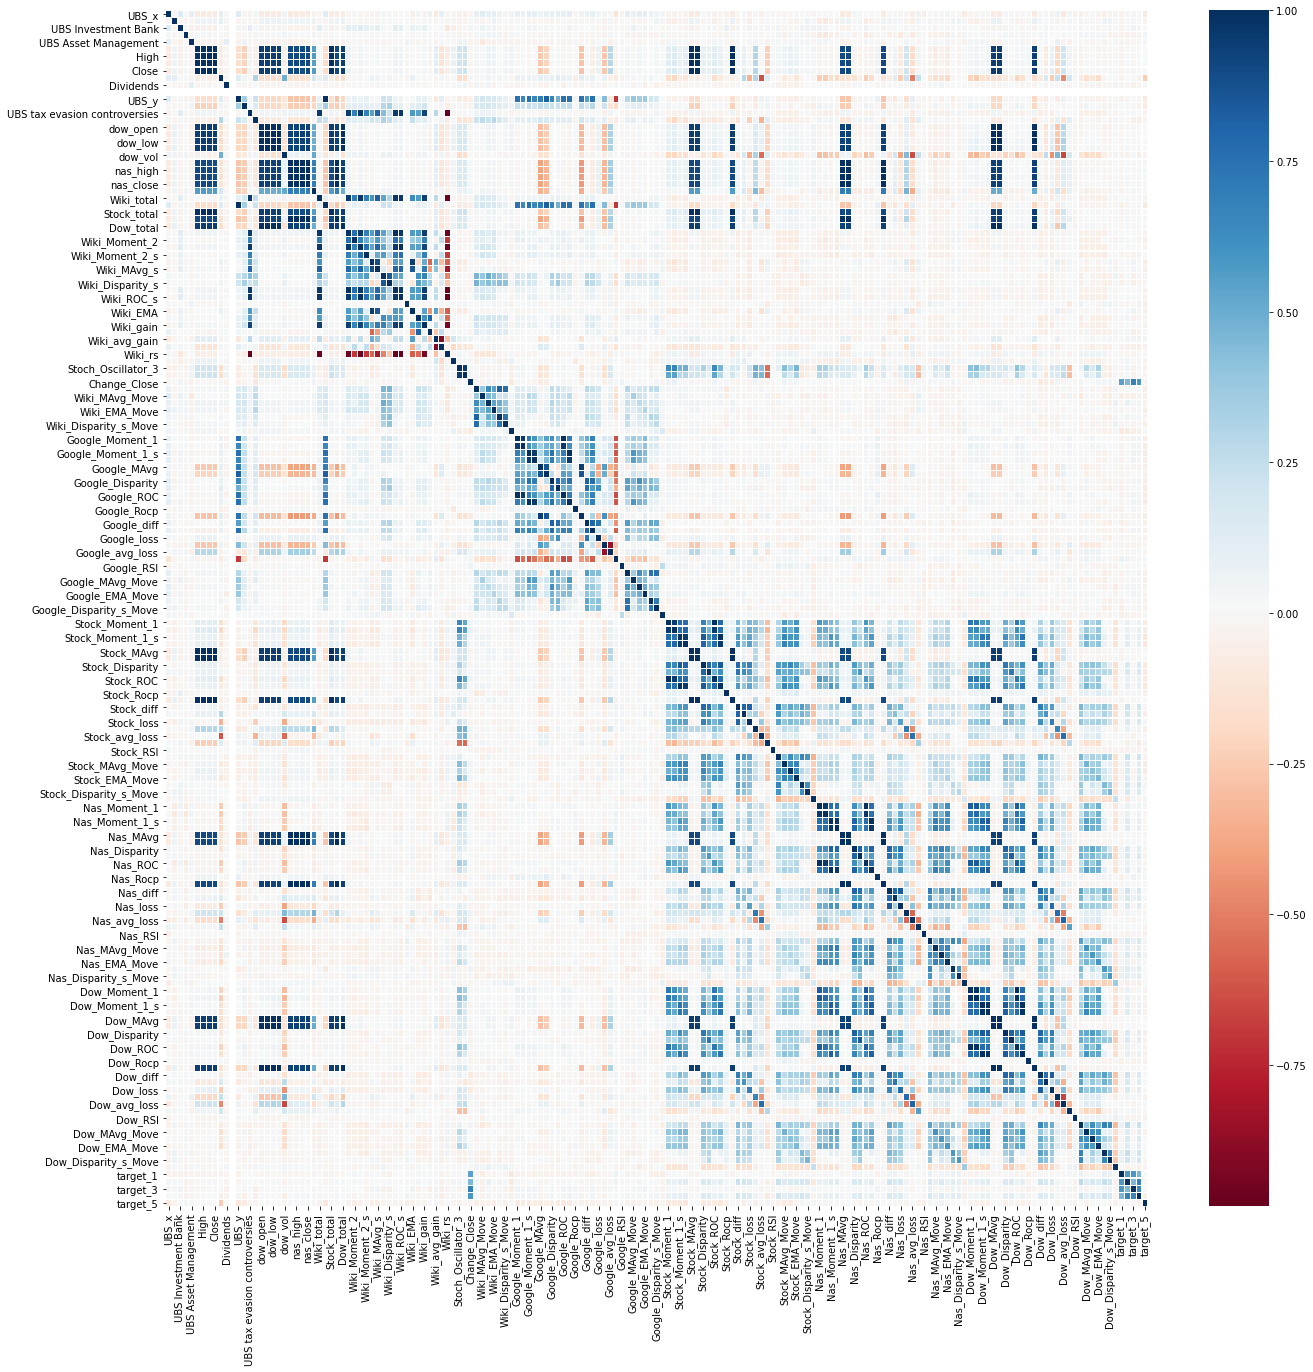

In [202]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(22, 22))
sns.heatmap(
    UBS.corr(),
    linewidths=0.1,
    cmap='RdBu',
)